In [ ]:
'''In this file we evaluate the state estimation with particle filtering in three different scenarios.
scenario 1: impact of sparsity on state estimation error
scenario 2: impact of observing different sets of state variables
scenario 3: having a constant and linear function for correct phase recognition'''

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import random
import statistics
import math

In [2]:
def interpolate_gaps(values, limit=None):
    """
    Fill gaps using linear interpolation, optionally only fill gaps up to a
    size of `limit`.
    """
    values = np.asarray(values)
    i = np.arange(values.size)
    valid = np.isfinite(values)
    filled = np.interp(i, i[valid], values[valid])

    if limit is not None:
        invalid = ~valid
        for n in range(1, limit+1):
            invalid[:-n] &= invalid[n:]
        filled[invalid] = np.nan

    return filled

In [3]:
def random_init_state(d_lower, d_upper, v_lower, v_upper, T_Y, T_G, T_R):
    
    '''
    randomly initialize a state in a given initial distribution for state variables
    '''
    actual_d_0 = np.random.uniform(d_lower, d_upper, 1)
    actual_v_0 = np.random.uniform(v_lower, v_upper, 1)
    actual_phi_probs = np.random.uniform(0, 1, 1)

    actual_phi_0 = np.full((actual_phi_probs.shape), '-')
    actual_phi_0[actual_phi_probs<(T_Y/total_T)] = 'Y'
    actual_phi_0[((actual_phi_probs>=(T_Y/total_T)) & (actual_phi_probs<((T_Y+T_G)/total_T)))] = 'G'
    actual_phi_0[actual_phi_probs>=((T_Y+T_G)/total_T)] = 'R'

    Y_occurance = np.count_nonzero(actual_phi_0 == 'Y')
    G_occurance = np.count_nonzero(actual_phi_0 == 'G')
    R_occurance = np.count_nonzero(actual_phi_0 == 'R')
    actual_t_phi_0 = np.full((actual_phi_probs.shape), 0)
    actual_t_phi_0[actual_phi_0=='Y'] = np.random.uniform(0, T_Y, Y_occurance)
    actual_t_phi_0[actual_phi_0=='G'] = np.random.uniform(0, T_G, G_occurance)
    actual_t_phi_0[actual_phi_0=='R'] = np.random.uniform(0, T_R, R_occurance)
    
    return actual_d_0, actual_v_0, actual_phi_0, actual_t_phi_0

In [4]:
def map_idx_to_state(idx, discrete_d, discrete_v, discrete_phi_t):
    '''
    To use Q-learning, we discretized our state space and each state has an index in Q-table.
    this function maps the index in the Q-table to the corresponding discretized state.
    '''
    len_1 = len(discrete_d)
    len_2 = len(discrete_v)
    len_3 = len(discrete_phi_t)
    
    idx_1 = int(np.floor(idx/(len_2*len_3)))
    distance = discrete_d[idx_1]
    
    idx_2 = int(np.floor((idx - idx_1*len_2*len_3)/len_3))
    velocity = discrete_v[idx_2]
    
    idx_3 = idx - idx_1*len_2*len_3 - idx_2*len_3

    phi = discrete_phi_t[idx_3].flatten()[0]
    t_phi = discrete_phi_t[idx_3].flatten()[1]
    
    return (distance, velocity, phi, t_phi)

In [5]:
def map_state_to_idx(state, discrete_d, discrete_v, discrete_phi_t, T_Y, T_R):
    '''
    To use Q-learning, we discretized our state space and each actual state is projected to a discretized state which has an index in Q-table.
    this function maps the actual state to the corresponding index in Q-table.
    '''
    distance = state[0]
    velocity = state[1]
    phi = state[2]
    t_phi = state[3]
    
    #find the closest discrete values of state variable to the actual values of state variables
    distance_diff = np.asarray([(distance - d)**2 for d in discrete_d])
    distance_idx = np.argmin(distance_diff)

    velocity_diff = np.asarray([(velocity - v)**2 for v in discrete_v])
    velocity_idx = np.argmin(velocity_diff)

    t_phi_candidates = np.asarray([int(x[1]) for x in discrete_phi_t if x[0]==phi])
    t_phi_diff = np.asarray([(t_phi - t)**2 for t in t_phi_candidates])
    t_phi_idx = np.argmin(t_phi_diff)
    if phi=='Y':
        phi_t_idx = t_phi_idx
    elif phi=='R':
        phi_t_idx = t_phi_idx + (T_Y+1)
    elif phi=='G':
        phi_t_idx = t_phi_idx + (T_Y+T_R+2)

    idx = distance_idx*len(discrete_v)*len(discrete_phi_t) + velocity_idx*len(discrete_phi_t) + phi_t_idx
    
    return idx
    

In [6]:
def action_selection(Q_row, actions, epsilon):
    '''
    this function finds the action at state, based on epsilon-greedy method
    Q-row is the row of the Q-table corresponding the state
    '''
    rand = np.random.uniform(0,1,1)
    if rand>epsilon:
        candidates = [i for i, x in enumerate(Q_row.flatten()) if x == np.max(Q_row.flatten())]
        action_idx = random.choice(candidates)
        
    else:
        action_idx = np.random.randint(0,len(actions))
        
    action = actions[action_idx]
    
    return action, action_idx

In [7]:
def particle_initialization(N, d_lower, d_upper, v_lower, v_upper, T_Y, T_G, T_R):
    '''initialize N particles in a given initial distribution for the state variables'''
    total_T = T_Y + T_G + T_R
    d_particle_0 = np.random.uniform(d_lower, d_upper, (N,1))
    v_particle_0 = np.random.uniform(v_lower, v_upper, (N,1))
    phi_probs = np.random.uniform(0, 1, (N,1)) # a probablity matrix of shape (N,1)

    #based on the T_Y, T_R, T_G, the interval of (0,1) is divided into 3 regions, each corresponds to a phase of Y, R or G.
    #each probability in array phi_probs is in one of these three regions, so the corresponding particle gets the phase of that region
    phi_particle_0 = np.full((phi_probs.shape), '-')
    phi_particle_0[phi_probs<(T_Y/total_T)] = 'Y'
    phi_particle_0[((phi_probs>=(T_Y/total_T)) & (phi_probs<((T_Y+T_G)/total_T)))] = 'G'
    phi_particle_0[phi_probs>=((T_Y+T_G)/total_T)] = 'R'
    
    #count the number of occurance for each phase
    Y_occurance = np.count_nonzero(phi_particle_0 == 'Y')
    G_occurance = np.count_nonzero(phi_particle_0 == 'G')
    R_occurance = np.count_nonzero(phi_particle_0 == 'R')
    t_phi_particle_0 = np.full((phi_probs.shape), 0)
    t_phi_particle_0[phi_particle_0 =='Y'] = np.random.uniform(0, T_Y, Y_occurance) #for the particles with the phase Y, t_phi is randomly generated in an interval (0,T_Y)
    t_phi_particle_0[phi_particle_0 =='G'] = np.random.uniform(0, T_G, G_occurance)
    t_phi_particle_0[phi_particle_0 =='R'] = np.random.uniform(0, T_R, R_occurance)

    return d_particle_0, v_particle_0, phi_particle_0, t_phi_particle_0

In [8]:
def update_state(state, action, delta_t, phi_T_dict, phi_to_next_phi_dict, std_d, std_v, std_t_phi):
    '''
    update the state with the action
    '''
    
    distance = state[0]
    velocity = state[1]
    phi = state[2][0]
    t_phi = state[3]
    
    distance = distance - velocity*delta_t - 0.5*action*(delta_t**2) + np.random.normal(0, std_d, 1)
    velocity = velocity + action*delta_t + np.random.normal(0, std_v, 1)
    
    if ((int(t_phi) + delta_t) <= (phi_T_dict[phi] + np.random.normal(0, std_t_phi, 1))):
        phi = phi
        t_phi = int(t_phi) + delta_t

    else:
        phi = phi_to_next_phi_dict[phi]
        t_phi = 0
        
    return (distance[0], velocity[0], phi, t_phi)

In [9]:
def state_process(N, steps, delta_t, d_0, v_0, phi_0, t_phi_0, a, std_d, std_v, std_t_phi):
    '''
    updates N particles with action a
    to generalized the function, it is assumed that steps can be more than 1, and the particles can go through state process for several steps, 
    but in our application the value for 'steps' is usually 1
    '''
    steps = steps + 1
    d = np.zeros((N, steps)) # create a zero-filled array with the shape (N, steps+1) for each state variable
    v = np.zeros((N, steps))
    phi = np.full((N, steps), '-')
    t_phi = np.zeros((N, steps))

    d[:, 0] = d_0.flatten() #the first column of the defined arrays is initialized with the given values of the partiles in the input
    v[:, 0] = v_0.flatten()
    phi[:, 0] = phi_0.flatten()
    t_phi[:, 0] = t_phi_0.flatten()

    for i in range(1,steps):
        d[:,i] = d[:,i-1] - v[:,i-1]*delta_t - 0.5*a*(delta_t**2) + np.random.normal(0, std_d, N) #the next columns of the arrays are filled with the updated state variables
        v[:,i] = v[:,i-1] + a*delta_t + np.random.normal(0, std_v, N)
        prev_T_phi = np.vectorize(phi_T_dict.get)(phi[:,i-1])
        curr_phi = np.vectorize(phi_next_phi_dict.get)(phi[:,i-1])
        for j in range(0,N):
            if ((t_phi[j,i-1] + delta_t) <= (prev_T_phi[j] + np.random.normal(0, std_t_phi, 1))):
                phi[j,i] = phi[j,i-1]
                t_phi[j,i] = t_phi[j,i-1] + delta_t
            else:
                phi[j,i] = curr_phi[j]
                t_phi[j,i] = np.random.uniform(0, delta_t, 1)
    
    return d[:,1:], v[:,1:], phi[:,1:], t_phi[:,1:]

In [10]:
def phi_likelihood(phi_obs_prob, phi_obs_prob_c, phi_obs, phi_particle):
    if phi_obs == phi_particle: #if the phase of the particle is the same as the observed phase, return the phase correct recognition probability
        return phi_obs_prob
    else:
        return phi_obs_prob_c

def normalize(w):
    n = len(w)
    w = np.asarray(w)
    # if np.all(w==0):
        # return np.random.uniform(0,1,n)
        # return np.full((w.shape),1/n)
    w_sum = np.sum(w)
    normalized_w = w/w_sum
    return normalized_w

In [92]:
def create_trajectories(d_lower, d_upper, v_lower, v_upper, discrete_d, discrete_v, discrete_phi_t, T_Y, T_G, T_R, phi_next_phi_dict, std_d, std_v, std_t_phi, std_d_m, std_v_m):
    '''in this function, first q-table is loaded, and then based on that the actual trajectory and the actions are generated, 
    then based on the actual trajectory, the measuremnets of the state are created.''' 
    delta_t=1
    
    #Loading Q-table
    with open('Q_table.npy','rb') as f:
        Q_table = np.load(f)
    
    
    #creating trajectories and the observation for 100 random trajectories
    all_trajectories = [] #the list for all 100 actual trajectories
    all_accelerations = [] #the list of all 100 series of actions
    obs_all_trajectories=[] #the list of 100 observed trajectories

    for i in range(100):
        trajectory = [] 
        acceleration = []
        obs_trajectory=[]

        state = random_init_state(d_lower, d_upper, v_lower, v_upper, T_Y, T_G, T_R) #randomly initialize a state in the range of given distribution
        idx_i = map_state_to_idx(state, discrete_d, discrete_v, discrete_phi_t, T_Y, T_R) #map the state to a index in Q-table
#         mapped_state = map_idx_to_state(idx_i, discrete_d, discrete_v, discrete_phi_t) 
        distance = state[0]
        
        while (distance>0):

            action, action_idx = action_selection(Q_table[idx_i], actions, 0) #the best action is selected based on the Q-table
            acceleration.append(action)

            state_new = update_state(state, action, delta_t, phi_T_dict, phi_next_phi_dict, std_d, std_v, std_t_phi) #update the state with selected action 
            idx_i_new = map_state_to_idx(state_new, discrete_d, discrete_v, discrete_phi_t, T_Y, T_R) #the index of the updated state in Q-table
            distance = state_new[0]

            state=state_new
            idx_i=idx_i_new
            
            trajectory.append(state)
            
            #generating observation based on the actual state and measurement noise
            d = state[0]
            v = state[1]
            phi = state[2]
            d_obs = d + np.random.normal(0,std_d_m,size=1)
            v_obs = v + np.random.normal(0,std_v_m,size=1)
            dummy_prob = np.random.uniform(0,1,1)
            
            if dummy_prob<phi_obs_prob:
                phi_obs = phi
            else: #if the dummy prob is less than the phi_obs_prob, a random phi is observed
                list1 = [ele for ele in phi_list if ele != phi]
                phi_obs = random.choice(list1)

            obs_state = (d_obs[0], v_obs[0], phi_obs)
            obs_trajectory.append(obs_state)

        all_trajectories.append(trajectory)
        all_accelerations.append(acceleration)
        obs_all_trajectories.append(obs_trajectory)
        
    return all_trajectories, all_accelerations, obs_all_trajectories


In [13]:
def missing_measurements(obs_all_trajectories, skip):
    '''based on the skip value, replace the unobserved state variables with NAN
    skip=1: low sparsity (we have observations each 2 seconds)
    skip=2: high sparsity (we have obervations every 3 seconds)'''
    skipped_obs_all_trajectories = []
    for obs_traj in obs_all_trajectories:
        skipped_obs_t =[]
        for s in range(len(obs_traj)):
            if s%(skip+1)==0:
                skipped_obs_t.append(obs_traj[s])
            else:
                skipped_obs_t.append((np.nan, np.nan, np.nan))
        
        skipped_obs_all_trajectories.append(skipped_obs_t)
        
    return skipped_obs_all_trajectories

In [14]:
def particle_filtering_missing_measurements(all_trajectories, all_accelerations, obs_all_trajectories, N, max_steps, phi_list, T_Y, T_R, T_G, phi_T_dict, phi_next_phi_dict, d_lower, d_upper, v_lower, v_upper, std_d, std_v, std_t_phi, std_d_m, std_v_m, phi_obs_prob):
    total_T = T_Y + T_G + T_R
    phi_obs_prob_c = (1-phi_obs_prob)/2 #the phase correct recognition probability is phi_obs_prob. the probabilty of observing the other two phases is phi_obs_prob_c
    
    '''Particle Filtering and State Estimation'''
    estimated_all_trajectories=[] #this list will contain the estimated trajectories for all 100 trajectories
    
    for traj_idx, traj in enumerate(obs_all_trajectories): #traj is a list of observations for one trajectory
        d_particle, v_particle, phi_particle, t_phi_particle = particle_initialization(N, d_lower, d_upper, v_lower, v_upper, T_Y, T_G, T_R) #initialize N particles with given initial distributions for state variables

        estimated_trajectory=[]

        d = d_particle.copy()
        v = v_particle.copy()
        phi = phi_particle.copy()
        t_phi = t_phi_particle.copy()

        for i in range(0, len(traj)):
            a= all_accelerations[traj_idx][i] #action taken at time i in the traj
            curr_d_particle, curr_v_particle, curr_phi_particle, curr_t_phi_particle = state_process(N, 1, delta_t, d, v, phi, t_phi, a, std_d, std_v, std_t_phi) #all particles go through state process with action a
            
            if not(math.isnan(traj[i][0])): #if at time i, observation is received
                weights = []
                d_obs = traj[i][0]
                v_obs = traj[i][1]
                phi_obs = traj[i][2]
                
                #calculate weight for each particle
                for j in range(0,N):
                    obs_likelihood = norm.pdf(d_obs, curr_d_particle[j,0], std_d_m) * norm.pdf(v_obs, curr_v_particle[j,0], std_v_m) * phi_likelihood(phi_obs_prob, phi_obs_prob_c, phi_obs, curr_phi_particle[j,0])
                    weights.append(obs_likelihood)

                normalized_weights = normalize(weights) #normalizing particle weights
                
                #determine the sampling index for the particles
                cum_weights = np.cumsum(normalized_weights)
                random_w = np.random.uniform(0,1,N)
                sampled_idx = []
                for idx, w in enumerate(random_w):
                    min_val = cum_weights[cum_weights>w].min()
                    sampled_idx.append(np.where(cum_weights==min_val)[0][0])
            else: #if there is no observation at time i, all the particles are passed
                sampled_idx = [m for m in range(len(curr_d_particle))]
                normalized_weights = normalize(N*[1])
            
            #estimating state variables using the particles and their weights
            estimated_d = np.dot(normalized_weights.T, curr_d_particle)
            estimated_v = np.dot(normalized_weights.T, curr_v_particle)
            
            #for estimating the phi and t_phi, first calculate the probability of each phi, and then select the phi with the greatest probability
            #then for the particles with that phi, compute the estimated t_phi 
            red_weights = np.sum(normalized_weights[curr_phi_particle.flatten()=='R'])
            yellow_weights = np.sum(normalized_weights[curr_phi_particle.flatten()=='Y'])
            green_weights = np.sum(normalized_weights[curr_phi_particle.flatten()=='G'])
            max_w = max(red_weights, yellow_weights, green_weights)
            if max_w == red_weights:
                estimated_phi = 'R'
                estimated_t_phi = np.dot(normalized_weights[curr_phi_particle.flatten()=='R'].T, curr_t_phi_particle[curr_phi_particle.flatten()=='R'])

            elif max_w == yellow_weights:
                estimated_phi = 'Y'
                estimated_t_phi = np.dot(normalized_weights[curr_phi_particle.flatten()=='Y'].T, curr_t_phi_particle[curr_phi_particle.flatten()=='Y'])

            elif max_w == green_weights:
                estimated_phi = 'G'
                estimated_t_phi = np.dot(normalized_weights[curr_phi_particle.flatten()=='G'].T, curr_t_phi_particle[curr_phi_particle.flatten()=='G'])


            estimated_trajectory.append((estimated_d[0], estimated_v[0], estimated_phi, estimated_t_phi[0]))
            
            #resampling the particles based on the previously determined index
            d = curr_d_particle[sampled_idx]
            v = curr_v_particle[sampled_idx]
            phi = curr_phi_particle[sampled_idx]
            t_phi = curr_t_phi_particle[sampled_idx]

        estimated_all_trajectories.append(estimated_trajectory)

    
    '''Evaluation'''
    
    max_traj_len = max([len(traj) for traj in all_trajectories])
    z=1.96
    
    d_MAE_list = [] #these lists will contain average estimation error of trajectories at each time step
    v_MAE_list = []
    t_MAE_list = []
    d_ci = [] #the list for the confidence interval of average error
    v_ci = []
    t_ci = []
    sample_size = []
    incorrect_phi_list=[] #for estimation error of phi, we calculate the average number of incorrect estimated phi
    for i in range(max_traj_len):
#         print(i)
        d_AE = []
        v_AE = []
        t_AE = []
        incorrect_phi=0
        
        actual_traj_candids = [traj for traj in all_trajectories if len(traj)>=(i+1)] #the actual trajectories with length at least i+1
        estimated_traj_candids = [traj for traj in estimated_all_trajectories if len(traj)>=(i+1)] #the estimated trajectories with length at least i+1
        if len(actual_traj_candids)<9: #to be able to compute confidence interval for the error of the trajectories at time i, we should have at least 2 trajectories that are longer than (i+1). I set the threshold to 9, to prevent very large confidence intervals at final time steps
            break
            
        sample_size.append(len(actual_traj_candids))
        #calculate the error
        for actual_t, estimated_t in zip(actual_traj_candids, estimated_traj_candids):
            d_err = abs(actual_t[i][0] - estimated_t[i][0])
            v_err = abs(actual_t[i][1] - estimated_t[i][1])
            t_err = abs(actual_t[i][3] - estimated_t[i][3])
            if actual_t[i][2]!=estimated_t[i][2]:
                incorrect_phi+=1
            d_AE.append(d_err)
            v_AE.append(v_err)
            t_AE.append(t_err)
        
        #averaging error at time i, over all trajectories that are longer than i
        d_MAE = sum(d_AE)/len(d_AE) 
        v_MAE = sum(v_AE)/len(v_AE)
        t_MAE = sum(t_AE)/len(t_AE)
        
        #Confidence interval 
        d_ci.append(z*statistics.stdev(d_AE)/math.sqrt(len(d_AE)))
        v_ci.append(z*statistics.stdev(v_AE)/math.sqrt(len(v_AE)))
        t_ci.append(z*statistics.stdev(t_AE)/math.sqrt(len(t_AE)))

        d_MAE_list.append(d_MAE)
        v_MAE_list.append(v_MAE)
        t_MAE_list.append(t_MAE)
        incorrect_phi_list.append(incorrect_phi/len(actual_traj_candids))
        
    return d_MAE_list, d_ci, v_MAE_list, v_ci, incorrect_phi_list, t_MAE_list, t_ci


In [15]:
            
def particle_filter_weights(N, scenario, state, curr_d_particle, curr_v_particle, curr_phi_particle, std_d_m, std_v_m, phi_obs_prob, phi_obs_prob_c):
    '''
    calculate weights of N particles
    '''
    weights = []
    if scenario==1: #we observe d, v, and phi
        d_obs = state[0] #observed distance
        v_obs = state[1] #observed velocity
        phi_obs = state[2] #observed phase

        for j in range(0,N): #for each particle, computes the likelihood of the particle and the observation
            obs_likelihood = norm.pdf(d_obs, curr_d_particle[j,0], std_d_m) * norm.pdf(v_obs, curr_v_particle[j,0], std_v_m) * phi_likelihood(phi_obs_prob, phi_obs_prob_c, phi_obs, curr_phi_particle[j,0])
            weights.append(obs_likelihood)
        
    if scenario==2: #we observe d, and v
        d_obs = state[0] #observed distacne
        v_obs = state[1] #observed velocity
    
        for j in range(0,N): #for each particle, computes the likelihood of the particle and the observation
            obs_likelihood = norm.pdf(d_obs, curr_d_particle[j,0], std_d_m) * norm.pdf(v_obs, curr_v_particle[j,0], std_v_m)
            weights.append(obs_likelihood)
            
    if scenario==3: #we observe v, and phi
        v_obs = state[0] #observed velocity
        phi_obs = state[1] #observed phase

        for j in range(0,N): #for each particle, computes the likelihood of the particle and the observation
            obs_likelihood = norm.pdf(v_obs, curr_v_particle[j,0], std_v_m) * phi_likelihood(phi_obs_prob, phi_obs_prob_c, phi_obs, curr_phi_particle[j,0])
            weights.append(obs_likelihood)
            
    return weights

In [16]:
def particle_filtering_different_observations(scenario, all_trajectories, all_accelerations, obs_all_trajectories, N, max_steps, phi_list, T_Y, T_R, T_G, phi_T_dict, phi_next_phi_dict, d_lower, d_upper, v_lower, v_upper, discrete_d, discrete_v, discrete_phi_t, std_d, std_v, std_d_m, std_v_m, phi_obs_prob):
    delta_t=1
        
    '''Particle Filtering and State Estimation for the case that we can have different sets of observations: (d,v,phi), (d,v) and (v,phi)'''
    estimated_all_trajectories=[]
    for traj_idx, traj in enumerate(obs_all_trajectories): #for each observed trajectory out of 100 observed trajectories
        d_particle, v_particle, phi_particle, t_phi_particle = particle_initialization(N, d_lower, d_upper, v_lower, v_upper, T_Y, T_G, T_R)

        estimated_trajectory=[]

        d = d_particle.copy()
        v = v_particle.copy()
        phi = phi_particle.copy()
        t_phi = t_phi_particle.copy()

        for i in range(0, len(traj)): #for each state in an observed trajectory
            a= all_accelerations[traj_idx][i] #action at state i
            
            curr_d_particle, curr_v_particle, curr_phi_particle, curr_t_phi_particle = state_process(N, 1, delta_t, d, v, phi, t_phi, a, std_d, std_v, std_t_phi) #state process of the particles with action a
            
            weights = particle_filter_weights(N, scenario, traj[i], curr_d_particle, curr_v_particle, curr_phi_particle, std_d_m, std_v_m, phi_obs_prob, phi_obs_prob_c) #calculate weights of the particles wrt the observed state traj[i]

            
            normalized_weights = normalize(weights)
            
            #determine the index of particles whcih are gonna be resampled
            cum_weights = np.cumsum(normalized_weights) #cumulative sum of normalized weights
            random_w = np.random.uniform(0,1,N)
            sampled_idx = []
            for idx, w in enumerate(random_w):
                min_val = cum_weights[cum_weights>w].min()
                sampled_idx.append(np.where(cum_weights==min_val)[0][0])
            
            #state estimation
            estimated_d = np.dot(normalized_weights.T, curr_d_particle)
            estimated_v = np.dot(normalized_weights.T, curr_v_particle)
            
            #for estimating the phi and t_phi, first calculate the probability of each phi (sum over the normalized weights of particles with that phi), and then select the phi with the greatest probability
            #then for the particles with that phi, compute the estimated t_phi 
            red_weights = np.sum(normalized_weights[curr_phi_particle.flatten()=='R'])
            yellow_weights = np.sum(normalized_weights[curr_phi_particle.flatten()=='Y'])
            green_weights = np.sum(normalized_weights[curr_phi_particle.flatten()=='G'])
            max_w = max(red_weights, yellow_weights, green_weights)
            if max_w == red_weights:
                estimated_phi = 'R'
                estimated_t_phi = np.dot(normalized_weights[curr_phi_particle.flatten()=='R'].T, curr_t_phi_particle[curr_phi_particle.flatten()=='R'])

            elif max_w == yellow_weights:
                estimated_phi = 'Y'
                estimated_t_phi = np.dot(normalized_weights[curr_phi_particle.flatten()=='Y'].T, curr_t_phi_particle[curr_phi_particle.flatten()=='Y'])

            elif max_w == green_weights:
                estimated_phi = 'G'
                estimated_t_phi = np.dot(normalized_weights[curr_phi_particle.flatten()=='G'].T, curr_t_phi_particle[curr_phi_particle.flatten()=='G'])

            estimated_trajectory.append((estimated_d[0], estimated_v[0], estimated_phi, estimated_t_phi[0]))
            
            #resampling the particles based on the sampling index list determined earlier
            d = curr_d_particle[sampled_idx]
            v = curr_v_particle[sampled_idx]
            phi = curr_phi_particle[sampled_idx]
            t_phi = curr_t_phi_particle[sampled_idx]

        estimated_all_trajectories.append(estimated_trajectory)
    
    
    '''Evaluation'''
    max_traj_len = max([len(traj) for traj in all_trajectories])
    z=1.96
    d_MAE_list = []
    v_MAE_list = []
    t_MAE_list = []
    d_ci = []
    v_ci = []
    t_ci = []
    sample_size = []
    incorrect_phi_list=[]
    for i in range(max_traj_len):
        d_AE = []
        v_AE = []
        incorrect_phi=0
        t_AE = []
        
        actual_traj_candids = [traj for traj in all_trajectories if len(traj)>=(i+1)]
        estimated_traj_candids = [traj for traj in estimated_all_trajectories if len(traj)>=(i+1)]
        
        if len(actual_traj_candids)<9:
            break
            
        sample_size.append(len(actual_traj_candids))
        for actual_t, estimated_t in zip(actual_traj_candids, estimated_traj_candids):
            d_err = abs(actual_t[i][0] - estimated_t[i][0])
            v_err = abs(actual_t[i][1] - estimated_t[i][1])
            t_err = abs(actual_t[i][3] - estimated_t[i][3])
            if actual_t[i][2]!=estimated_t[i][2]:
                incorrect_phi+=1
            d_AE.append(d_err)
            v_AE.append(v_err)
            t_AE.append(t_err)

        d_MAE = sum(d_AE)/len(d_AE)
        v_MAE = sum(v_AE)/len(v_AE)
        t_MAE = sum(t_AE)/len(t_AE)
        d_ci.append(z*statistics.stdev(d_AE)/math.sqrt(len(d_AE)))
        v_ci.append(z*statistics.stdev(v_AE)/math.sqrt(len(v_AE)))
        t_ci.append(z*statistics.stdev(t_AE)/math.sqrt(len(t_AE)))

        d_MAE_list.append(d_MAE)
        v_MAE_list.append(v_MAE)
        incorrect_phi_list.append(incorrect_phi/len(actual_traj_candids))
        t_MAE_list.append(t_MAE)
    
    
            
    return d_MAE_list, d_ci, v_MAE_list, v_ci, incorrect_phi_list, t_MAE_list, t_ci

        

In [94]:
def particle_filtering_phi_prob(scenario, all_trajectories, all_accelerations, obs_all_trajectories, N, max_steps, phi_list, T_Y, T_R, T_G, phi_T_dict, phi_next_phi_dict, d_lower, d_upper, v_lower, v_upper, discrete_d, discrete_v, discrete_phi_t, std_d, std_v, std_d_m, std_v_m, phi_obs_prob):
    delta_t=1
        
    '''Particle Filtering and State Estimation for the case that we have both a constant value and a linear function for correct phase recognition'''
    estimated_all_trajectories=[]
    for traj_idx, traj in enumerate(obs_all_trajectories): #for each observed trajectory out of 100 trajectories
        d_particle, v_particle, phi_particle, t_phi_particle = particle_initialization(N, d_lower, d_upper, v_lower, v_upper, T_Y, T_G, T_R)#initialize the particles in a given initial distribution for the state variables

        estimated_trajectory=[]

        d = d_particle.copy()
        v = v_particle.copy()
        phi = phi_particle.copy()
        t_phi = t_phi_particle.copy()

        for i in range(0, len(traj)): #loop on the states of one observed trajectory
            a= all_accelerations[traj_idx][i] #action taken at state i
            curr_d_particle, curr_v_particle, curr_phi_particle, curr_t_phi_particle = state_process(N, 1, delta_t, d, v, phi, t_phi, a, std_d, std_v, std_t_phi) #the particles go through the state process with action a
            
            weights=[]
            d_obs = traj[i][0] #observed distance at state i
            v_obs = traj[i][1] #observed velocity at state i
            phi_obs = traj[i][2] #observed phase at state i

            for j in range(0,N): #loop on the N particles
                if scenario=='v': # v stands for variable (not constant). Here a linear function is defined for the correct phase recognition
                    phi_obs_prob = min(((-(0.9-phi_obs_prob)/d_upper)*curr_d_particle[j,0])+0.9,0.9)
            
                phi_obs_prob_c = (1-phi_obs_prob)/2 #the probability of the correct phase recognition is phi_obs_prob. the probability of observing the other two phases is phi_obs_prob_c

                #find the likelihood of the particle and the observation at this time step
                obs_likelihood = norm.pdf(d_obs, curr_d_particle[j,0], std_d_m) * norm.pdf(v_obs, curr_v_particle[j,0], std_v_m) * phi_likelihood(phi_obs_prob, phi_obs_prob_c, phi_obs, curr_phi_particle[j,0])

                weights.append(obs_likelihood)

            
            normalized_weights = normalize(weights) #normalize the weights
            
            #determine the index for the resampling of the particles
            cum_weights = np.cumsum(normalized_weights) #cumulative sum of normalized weights
            random_w = np.random.uniform(0,1,N) #generate N random probability. 
            sampled_idx = []
            for idx, w in enumerate(random_w):
                min_val = cum_weights[cum_weights>w].min() 
                sampled_idx.append(np.where(cum_weights==min_val)[0][0])
            
            #state estimation 
            estimated_d = np.dot(normalized_weights.T, curr_d_particle) #estimation of distance
            estimated_v = np.dot(normalized_weights.T, curr_v_particle) #estimation of velocity
            
            #for estimating the phi and t_phi, first calculate the probability of each phi, and then select the phi with the greatest probability
            #then for the particles with that phi, compute the estimated t_phi 
            red_weights = np.sum(normalized_weights[curr_phi_particle.flatten()=='R']) 
            yellow_weights = np.sum(normalized_weights[curr_phi_particle.flatten()=='Y'])
            green_weights = np.sum(normalized_weights[curr_phi_particle.flatten()=='G'])
            max_w = max(red_weights, yellow_weights, green_weights)
            if max_w == red_weights:
                estimated_phi = 'R'
                estimated_t_phi = np.dot(normalized_weights[curr_phi_particle.flatten()=='R'].T, curr_t_phi_particle[curr_phi_particle.flatten()=='R'])

            elif max_w == yellow_weights:
                estimated_phi = 'Y'
                estimated_t_phi = np.dot(normalized_weights[curr_phi_particle.flatten()=='Y'].T, curr_t_phi_particle[curr_phi_particle.flatten()=='Y'])

            elif max_w == green_weights:
                estimated_phi = 'G'
                estimated_t_phi = np.dot(normalized_weights[curr_phi_particle.flatten()=='G'].T, curr_t_phi_particle[curr_phi_particle.flatten()=='G'])

            estimated_trajectory.append((estimated_d[0], estimated_v[0], estimated_phi, estimated_t_phi[0]))
            
            #resampling the particles based on the index we calculated earlier
            d = curr_d_particle[sampled_idx]
            v = curr_v_particle[sampled_idx]
            phi = curr_phi_particle[sampled_idx]
            t_phi = curr_t_phi_particle[sampled_idx]

        estimated_all_trajectories.append(estimated_trajectory)
    
    
    '''Evaluation'''
    max_traj_len = max([len(traj) for traj in all_trajectories])
#     print((all_trajectories))
    z=1.96
    d_MAE_list = []
    v_MAE_list = []
    t_MAE_list = []
    d_ci = []
    v_ci = []
    t_ci = []
    sample_size = []
    incorrect_phi_list=[]
    for i in range(max_traj_len):
        d_AE = []
        v_AE = []
        incorrect_phi=0
        t_AE = []
        
        actual_traj_candids = [traj for traj in all_trajectories if len(traj)>=(i+1)]
        estimated_traj_candids = [traj for traj in estimated_all_trajectories if len(traj)>=(i+1)]
        
        if len(actual_traj_candids)<9:
            break
            
        sample_size.append(len(actual_traj_candids))
        for actual_t, estimated_t in zip(actual_traj_candids, estimated_traj_candids):
            d_err = abs(actual_t[i][0] - estimated_t[i][0])
            v_err = abs(actual_t[i][1] - estimated_t[i][1])
            t_err = abs(actual_t[i][3] - estimated_t[i][3])
            if actual_t[i][2]!=estimated_t[i][2]:
                incorrect_phi+=1
            d_AE.append(d_err)
            v_AE.append(v_err)
            t_AE.append(t_err)

        d_MAE = sum(d_AE)/len(d_AE)
        v_MAE = sum(v_AE)/len(v_AE)
        t_MAE = sum(t_AE)/len(t_AE)
        d_ci.append(z*statistics.stdev(d_AE)/math.sqrt(len(d_AE)))
        v_ci.append(z*statistics.stdev(v_AE)/math.sqrt(len(v_AE)))
        t_ci.append(z*statistics.stdev(t_AE)/math.sqrt(len(t_AE)))

        d_MAE_list.append(d_MAE)
        v_MAE_list.append(v_MAE)
        incorrect_phi_list.append(incorrect_phi/len(actual_traj_candids))
        t_MAE_list.append(t_MAE)
    
    
            
    return d_MAE_list, d_ci, v_MAE_list, v_ci, incorrect_phi_list, t_MAE_list, t_ci

        

In [160]:
T_Y = 5 #length of Yellow phase
T_G = 10 #length of Green phase
T_R = 10 #lenght of Red phase
total_T = T_Y + T_G + T_R

delta_t = 1

phi_list = ['Y','G','R']
phi_T_dict = {'Y': T_Y, 'G': T_G, 'R': T_R} #the dictionary to map each phase to its timing
phi_next_phi_dict = {'G':'Y', 'Y':'R', 'R':'G'} #the dictionary to map each phase to its next phase

actions = np.asarray([-3, -2, -1, 0, 1, 2, 3]) #list of the actions
discrete_d = np.arange(-8, 121, 8) #the discretized values of ditance
v_max=15
discrete_v = np.arange(0, v_max+1, 1) #the discretized values of velocity

#the discretized values of (phi, t_phi)
discrete_phi_t = np.asarray([('Y', 0), ('Y', 1), ('Y', 2), ('Y', 3), ('Y', 4), ('Y', 5)\
                            , ('R', 0), ('R', 1), ('R', 2), ('R', 3), ('R', 4), ('R', 5), ('R', 6), ('R', 7), ('R', 8), ('R', 9), ('R', 10)\
                            , ('G', 0), ('G', 1), ('G', 2), ('G', 3), ('G', 4), ('G', 5), ('G', 6), ('G', 7), ('G', 8), ('G', 9), ('G', 10)])
N = 10000 #number of particles
max_steps = 100 #number of trajectories

std_d = 2 #standard deviation of state process noise of distance
std_v = 2 #standard deviation of state process noise of velocity
std_t_phi = 2 #standard deviation of state process noise of t_phi
std_d_m = 2 #standard deviation of measurement noise of distance
std_v_m = 2 #standard deviation of measurement noise of velocity

d_lower = 90 #lower bound for the initial distribution for distance
d_upper = 120 #uper bound for the initial distribution for distance

v_lower = 10 #lower bound for the initial distribution for velocity
v_upper = 15 #upper bound for the initial distribution for velocity

phi_obs_prob = 0.8 #the probability of correct phase recognition
phi_obs_prob_c = (1-phi_obs_prob)/2 #the probability of wrong phase recognition (for each of the wrong phases)


In [161]:
#generate 100 random trajectories, with the selected actions in each trajectory, and observed trajectories
all_trajectories, all_accelerations, obs_all_trajectories = create_trajectories(d_lower, d_upper, v_lower, v_upper, discrete_d, discrete_v, discrete_phi_t, T_Y, T_G, T_R, phi_next_phi_dict, std_d, std_v, std_t_phi, std_d_m, std_v_m, 'c',phi_obs_prob)


In [162]:
#returns the average error and confidence interval for state estimation using particle filtering, in the no sparsity scenario that all state variables are observed at all time steps
d_MAE_list_skip_0, d_ci_skip_0, v_MAE_list_skip_0, v_ci_skip_0, incorrect_phi_list_skip_0, t_MAE_list_skip_0, t_ci_skip_0 = particle_filtering_missing_measurements(all_trajectories, all_accelerations, obs_all_trajectories, N, max_steps, phi_list, T_Y, T_R, T_G, phi_T_dict, phi_next_phi_dict, d_lower, d_upper, v_lower, v_upper, std_d, std_v, std_t_phi, std_d_m, std_v_m, phi_obs_prob)


In [163]:
#Replace one observation in a row with 'NAN' to generate the observations for the case of low sparsity, in which the observations are received every 2 seconds
skipped_obs_all_trajectories_1 = missing_measurements(obs_all_trajectories, 1)

#returns the average error and confidence interval for state estimation using particle filtering, in the low sparsity scenario that observations are received every 2 seconds
d_MAE_list_skip_1, d_ci_skip_1, v_MAE_list_skip_1, v_ci_skip_1, incorrect_phi_list_skip_1, t_MAE_list_skip_1, t_ci_skip_1 = particle_filtering_missing_measurements(all_trajectories, all_accelerations, skipped_obs_all_trajectories_1, N, max_steps, phi_list, T_Y, T_R, T_G, phi_T_dict, phi_next_phi_dict, d_lower, d_upper, v_lower, v_upper, std_d, std_v, std_t_phi, std_d_m, std_v_m, phi_obs_prob)


In [164]:
# Replace the observations with "NaN" in this way: 2 NaN, 1 observation, 2 NaN, 1 observation..., for the high sparsity scenario that we have the observations every 3 seconds
skipped_obs_all_trajectories_2 = missing_measurements(obs_all_trajectories, 2)

#returns the average error and confidence interval for state estimation using particle filtering, in the high sparsity scenario that observations are received every 3 seconds
d_MAE_list_skip_2, d_ci_skip_2, v_MAE_list_skip_2, v_ci_skip_2, incorrect_phi_list_skip_2, t_MAE_list_skip_2, t_ci_skip_2 = particle_filtering_missing_measurements(all_trajectories, all_accelerations, skipped_obs_all_trajectories_2, N, max_steps, phi_list, T_Y, T_R, T_G, phi_T_dict, phi_next_phi_dict, d_lower, d_upper, v_lower, v_upper, std_d, std_v, std_t_phi, std_d_m, std_v_m, phi_obs_prob)


In [165]:
font = {'family' : 'normal',
        'size'   : 30}

plt.rc('font', **font)

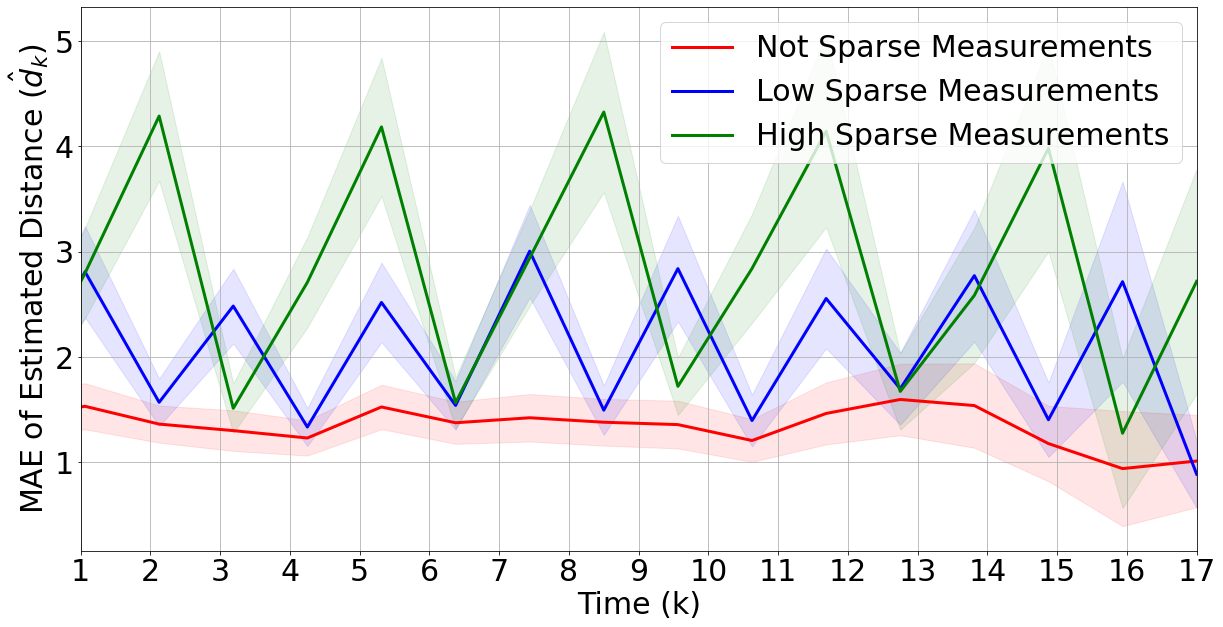

In [166]:
#Plot MAE of Estimated Distance vs. Time, for three scenarios of no sparsity, low sparsity, high sparsity

steps = min(len(d_MAE_list_skip_0), len(d_MAE_list_skip_1), len(d_MAE_list_skip_2))
t = np.linspace(0, steps, steps)

d_lower_ci_skip_0 = [d_MAE_list_skip_0[i]-d_ci_skip_0[i] for i in range(steps)]
d_upper_ci_skip_0 = [d_MAE_list_skip_0[i]+d_ci_skip_0[i] for i in range(steps)]

d_lower_ci_skip_1 = [d_MAE_list_skip_1[i]-d_ci_skip_1[i] for i in range(steps)]
d_upper_ci_skip_1 = [d_MAE_list_skip_1[i]+d_ci_skip_1[i] for i in range(steps)]

d_lower_ci_skip_2 = [d_MAE_list_skip_2[i]-d_ci_skip_2[i] for i in range(steps)]
d_upper_ci_skip_2 = [d_MAE_list_skip_2[i]+d_ci_skip_2[i] for i in range(steps)]

plt.figure(figsize=(20,10))

plt.plot(t,d_MAE_list_skip_0[:steps], color='r', label='Not Sparse Measurements', linewidth=3)
plt.fill_between(t, d_lower_ci_skip_0, d_upper_ci_skip_0, color='r', alpha=.1)


plt.plot(t,d_MAE_list_skip_1[:steps], color='b', label='Low Sparse Measurements', linewidth=3 )
plt.fill_between(t, d_lower_ci_skip_1, d_upper_ci_skip_1, color='b', alpha=.1)

plt.plot(t,d_MAE_list_skip_2[:steps], color='g', label='High Sparse Measurements', linewidth=3)
plt.fill_between(t, d_lower_ci_skip_2, d_upper_ci_skip_2, color='g', alpha=.1)

# plt.title('MAE for Estimation of Distance, with Confidence Interval of 90%')
plt.xlabel('Time (k)')
plt.xticks(np.arange(steps+1), np.arange(0, steps+1))
plt.xlim((1,steps))
plt.ylabel(r'MAE of Estimated Distance ($\hat d_k$)')
# MAE of Estimated Distance ({\hat{d}}_{k})
plt.legend(loc='upper right')
plt.grid()
plt.savefig('d_MAE_missingMeasurement.png',bbox_inches='tight')
plt.show()


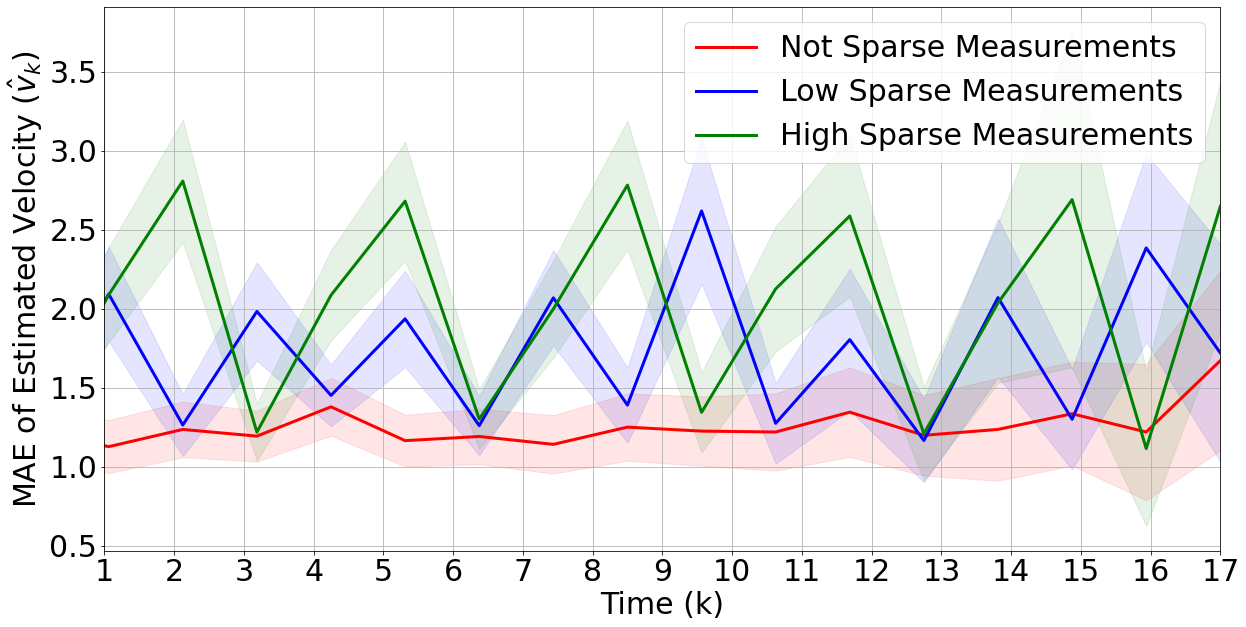

In [167]:
#Plot MAE of Estimated Velocity vs. Time, for three scenarios of no sparsity, low sparsity, high sparsity


steps = min(len(v_MAE_list_skip_0), len(v_MAE_list_skip_1), len(v_MAE_list_skip_2))
t = np.linspace(0, steps, steps)

v_lower_ci_skip_0 = [v_MAE_list_skip_0[i]-v_ci_skip_0[i] for i in range(steps)]
v_upper_ci_skip_0 = [v_MAE_list_skip_0[i]+v_ci_skip_0[i] for i in range(steps)]

v_lower_ci_skip_1 = [v_MAE_list_skip_1[i]-v_ci_skip_1[i] for i in range(steps)]
v_upper_ci_skip_1 = [v_MAE_list_skip_1[i]+v_ci_skip_1[i] for i in range(steps)]

v_lower_ci_skip_2 = [v_MAE_list_skip_2[i]-v_ci_skip_2[i] for i in range(steps)]
v_upper_ci_skip_2 = [v_MAE_list_skip_2[i]+v_ci_skip_2[i] for i in range(steps)]

plt.figure(figsize=(20,10))

plt.plot(t,v_MAE_list_skip_0[:steps], color='r', label='Not Sparse Measurements', linewidth=3)
plt.fill_between(t, v_lower_ci_skip_0, v_upper_ci_skip_0, color='r', alpha=.1)


plt.plot(t,v_MAE_list_skip_1[:steps], color='b', label='Low Sparse Measurements' , linewidth=3)
plt.fill_between(t, v_lower_ci_skip_1, v_upper_ci_skip_1, color='b', alpha=.1)

plt.plot(t,v_MAE_list_skip_2[:steps], color='g', label='High Sparse Measurements', linewidth=3)
plt.fill_between(t, v_lower_ci_skip_2, v_upper_ci_skip_2, color='g', alpha=.1)

# plt.title('MAE for Estimation of Velocity, with Confidence Interval of 90%')
plt.xlabel('Time (k)')
plt.xticks(np.arange(steps+1), np.arange(0, steps+1))
plt.xlim((1,steps))
plt.ylabel(r'MAE of Estimated Velocity ($\hat v_k$)')
plt.legend(loc='upper right')
plt.grid()
plt.savefig('v_MAE_missingMeasurements.png',bbox_inches='tight')
plt.show()


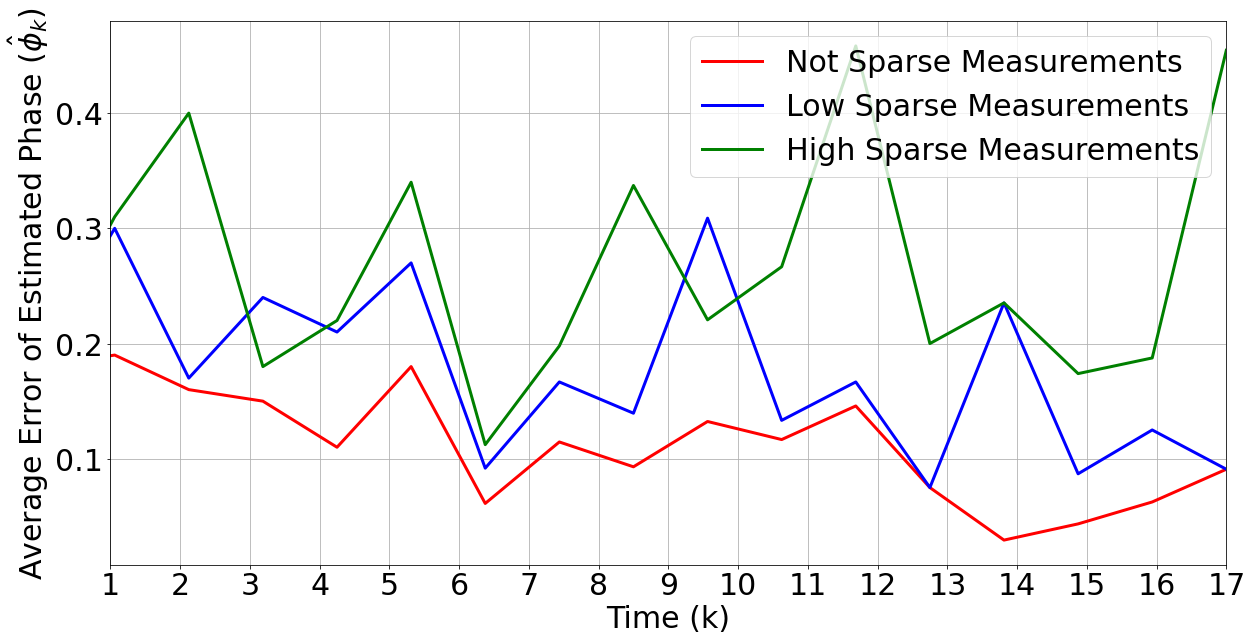

In [168]:
#Plot Average Error of Estimated Phase vs. Time, for three scenarios of no sparsity, low sparsity, high sparsity

steps = min(len(incorrect_phi_list_skip_0), len(incorrect_phi_list_skip_1))#, len(incorrect_phi_list_2))
t = np.linspace(0, steps, steps)

plt.figure(figsize=(20,10))
plt.plot(t,incorrect_phi_list_skip_0[:steps], color='r', label='Not Sparse Measurements', linewidth=3)

plt.plot(t,incorrect_phi_list_skip_1[:steps], color='b', label='Low Sparse Measurements', linewidth=3)

plt.plot(t,incorrect_phi_list_skip_2[:steps], color='g', label='High Sparse Measurements', linewidth=3)

# plt.title('Error of Phase Estimation')
plt.xlabel('Time (k)')
plt.xticks(np.arange(steps+1), np.arange(0, steps+1))
plt.xlim((1,steps))
plt.ylabel(r'Average Error of Estimated Phase ($\hat \phi_k$)')
# Average Error of Estimated Phase ({\hat{\phi}}_{k})
plt.legend(loc='upper right')
plt.grid()
plt.savefig('PhaseError_missingMeasurement.png',bbox_inches='tight')
plt.show()

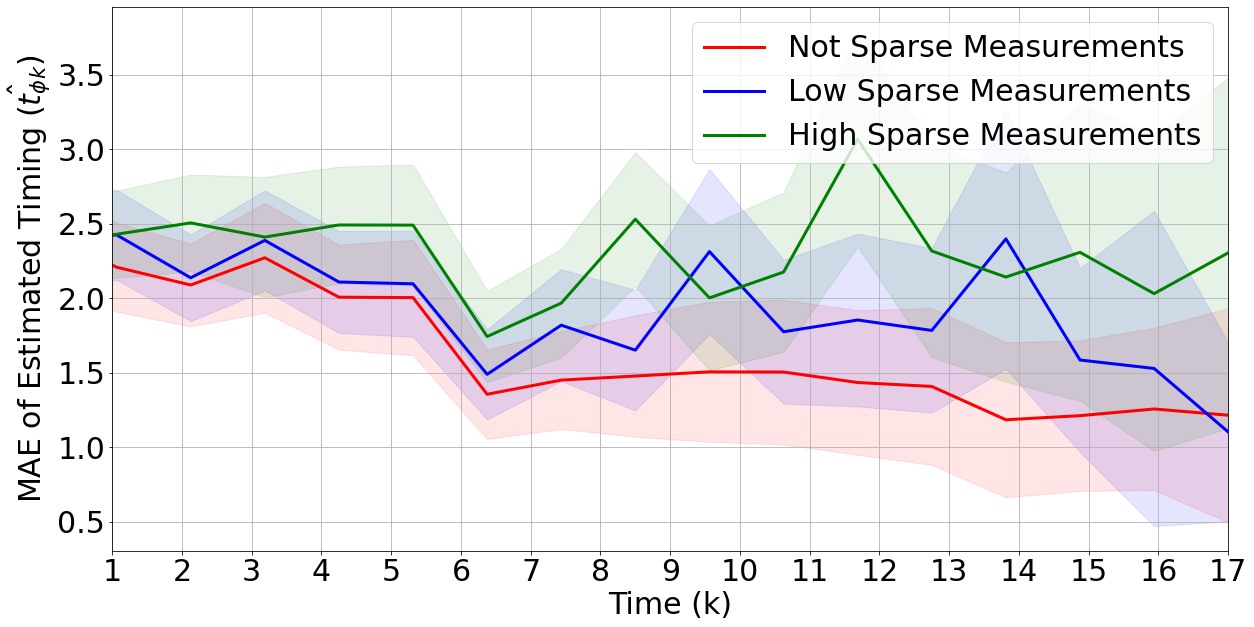

In [169]:
#Plot MAE of Estimated Timing vs. Time, for three scenarios of no sparsity, low sparsity, high sparsity


steps = min(len(t_MAE_list_skip_0), len(t_MAE_list_skip_1), len(t_MAE_list_skip_2))
t = np.linspace(0, steps, steps)

t_lower_ci_skip_0 = [t_MAE_list_skip_0[i]-t_ci_skip_0[i] for i in range(steps)]
t_upper_ci_skip_0 = [t_MAE_list_skip_0[i]+t_ci_skip_0[i] for i in range(steps)]

t_lower_ci_skip_1 = [t_MAE_list_skip_1[i]-t_ci_skip_1[i] for i in range(steps)]
t_upper_ci_skip_1 = [t_MAE_list_skip_1[i]+t_ci_skip_1[i] for i in range(steps)]

t_lower_ci_skip_2 = [t_MAE_list_skip_2[i]-t_ci_skip_2[i] for i in range(steps)]
t_upper_ci_skip_2 = [t_MAE_list_skip_2[i]+t_ci_skip_2[i] for i in range(steps)]

plt.figure(figsize=(20,10))

plt.plot(t,t_MAE_list_skip_0[:steps], color='r', label='Not Sparse Measurements', linewidth=3)
plt.fill_between(t, t_lower_ci_skip_0, t_upper_ci_skip_0, color='r', alpha=.1)


plt.plot(t,t_MAE_list_skip_1[:steps], color='b', label='Low Sparse Measurements', linewidth=3 )
plt.fill_between(t, t_lower_ci_skip_1, t_upper_ci_skip_1, color='b', alpha=.1)

plt.plot(t,t_MAE_list_skip_2[:steps], color='g', label='High Sparse Measurements', linewidth=3)
plt.fill_between(t, t_lower_ci_skip_2, t_upper_ci_skip_2, color='g', alpha=.1)

# plt.title('MAE for Estimation of Time of Phase, with Confidence Interval of 90%')
plt.xlabel('Time (k)')
plt.xticks(np.arange(steps+1), np.arange(0, steps+1))
plt.xlim((1,steps))
plt.ylabel(r'MAE of Estimated Timing ($\hat {t_\phi}_k$)')
# MAE of Estimated Timing (\hat{t}_{{\phi}_{k}})
plt.legend(loc='upper right')
plt.grid()
plt.savefig('t_MAE_missingMeasurement.png',bbox_inches='tight')
plt.show()


In [170]:
#returns the average state estimation error for the case that (d,v,phi) are observed
d_MAE_list_obs_1, d_ci_obs_1, v_MAE_list_obs_1, v_ci_obs_1, incorrect_phi_list_obs_1, t_MAE_list_obs_1, t_ci_obs_1 = particle_filtering_different_observations(1, all_trajectories, all_accelerations, obs_all_trajectories, N, max_steps, phi_list, T_Y, T_R, T_G, phi_T_dict, phi_next_phi_dict, d_lower, d_upper, v_lower, v_upper, discrete_d, discrete_v, discrete_phi_t, std_d, std_v, std_d_m, std_v_m, phi_obs_prob)


In [171]:
#create the observation list for the case that (d,v) are observed

obs_all_trajectories_2 = []
for traj in obs_all_trajectories: #loop over 100 observed trajectories
    obs_traj = []
    for idx, state in enumerate(traj): #loop over each observed trajectory
        obs = (state[0], state[1]) #state[0] is the distance, ans state[1] is the velocity. obs contains only distance and velocity
        obs_traj.append(obs)
    obs_all_trajectories_2.append(obs_traj)

#returns the average state estimation error for the case that (d,v) are observed
d_MAE_list_obs_2, d_ci_obs_2, v_MAE_list_obs_2, v_ci_obs_2, incorrect_phi_list_obs_2, t_MAE_list_obs_2, t_ci_obs_2 = particle_filtering_different_observations(2, all_trajectories, all_accelerations, obs_all_trajectories_2, N, max_steps, phi_list, T_Y, T_R, T_G, phi_T_dict, phi_next_phi_dict, d_lower, d_upper, v_lower, v_upper, discrete_d, discrete_v, discrete_phi_t, std_d, std_v, std_d_m, std_v_m, phi_obs_prob)


In [172]:
obs_all_trajectories_3 = []
for traj in obs_all_trajectories:
    obs_traj = []
    for idx, state in enumerate(traj):
        obs = (state[1], state[2]) #state[1] is the velocity, ans state[2] is the phi. obs contains only velocity and phi
        obs_traj.append(obs)
    obs_all_trajectories_3.append(obs_traj)
    
#returns the average state estimation error for the case that (v,phi) are observed
d_MAE_list_obs_3, d_ci_obs_3, v_MAE_list_obs_3, v_ci_obs_3, incorrect_phi_list_obs_3, t_MAE_list_obs_3, t_ci_obs_3 = particle_filtering_different_observations(3, all_trajectories, all_accelerations, obs_all_trajectories_3, N, max_steps, phi_list, T_Y, T_R, T_G, phi_T_dict, phi_next_phi_dict, d_lower, d_upper, v_lower, v_upper, discrete_d, discrete_v, discrete_phi_t, std_d, std_v, std_d_m, std_v_m, phi_obs_prob)


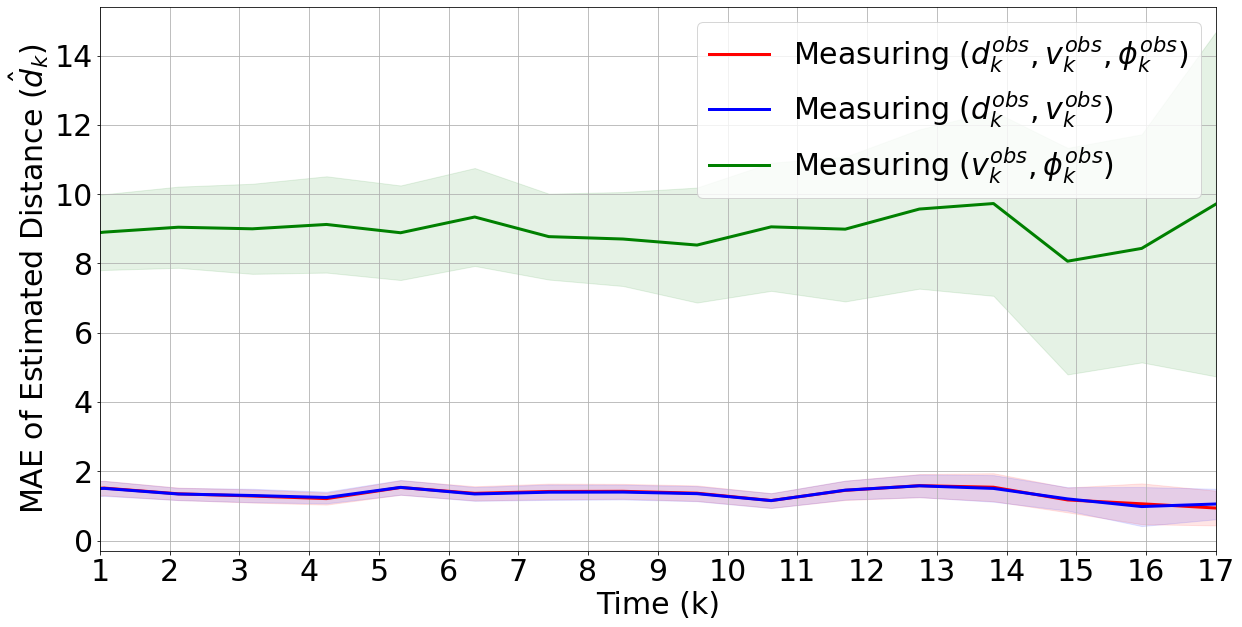

In [183]:
# plot MAE of Estimated Distance for different sets of measurements

steps = min(len(d_MAE_list_obs_1), len(d_MAE_list_obs_2), len(d_MAE_list_obs_3))
t = np.linspace(0, steps, steps)

d_lower_ci_obs_1 = [d_MAE_list_obs_1[i]-d_ci_obs_1[i] for i in range(steps)]
d_upper_ci_obs_1 = [d_MAE_list_obs_1[i]+d_ci_obs_1[i] for i in range(steps)]

d_lower_ci_obs_2 = [d_MAE_list_obs_2[i]-d_ci_obs_2[i] for i in range(steps)]
d_upper_ci_obs_2 = [d_MAE_list_obs_2[i]+d_ci_obs_2[i] for i in range(steps)]

d_lower_ci_obs_3 = [d_MAE_list_obs_3[i]-d_ci_obs_3[i] for i in range(steps)]
d_upper_ci_obs_3 = [d_MAE_list_obs_3[i]+d_ci_obs_3[i] for i in range(steps)]

plt.figure(figsize=(20,10))

plt.plot(t,d_MAE_list_obs_1[:steps], color='r', label=r'Measuring ($d^{obs}_k ,v^{obs}_k, \phi^{obs}_k$)', linewidth=3)
# Measuring (d^{obs}_k \, , \, v^{obs}_k  \, , \, \phi^{obs}_k)
plt.fill_between(t, d_lower_ci_obs_1, d_upper_ci_obs_1, color='r', alpha=.1)


plt.plot(t,d_MAE_list_obs_2[:steps], color='b', label=r'Measuring ($d^{obs}_k ,v^{obs}_k$)' , linewidth=3)
plt.fill_between(t, d_lower_ci_obs_2, d_upper_ci_obs_2, color='b', alpha=.1)

plt.plot(t,d_MAE_list_obs_3[:steps], color='g', label=r'Measuring ($v^{obs}_k, \phi^{obs}_k$)', linewidth=3)
plt.fill_between(t, d_lower_ci_obs_3, d_upper_ci_obs_3, color='g', alpha=.1)

# plt.title('MAE for Estimation of Distance, with Confidence Interval of 90%')
plt.xlabel('Time (k)')
plt.xticks(np.arange(steps+1), np.arange(0, steps+1))
plt.xlim((1,steps))
plt.ylabel(r'MAE of Estimated Distance ($\hat d_k$)')
plt.legend(loc='upper right')
plt.grid()

plt.savefig('d_MAE_differentObservation.png',bbox_inches='tight')
plt.show()

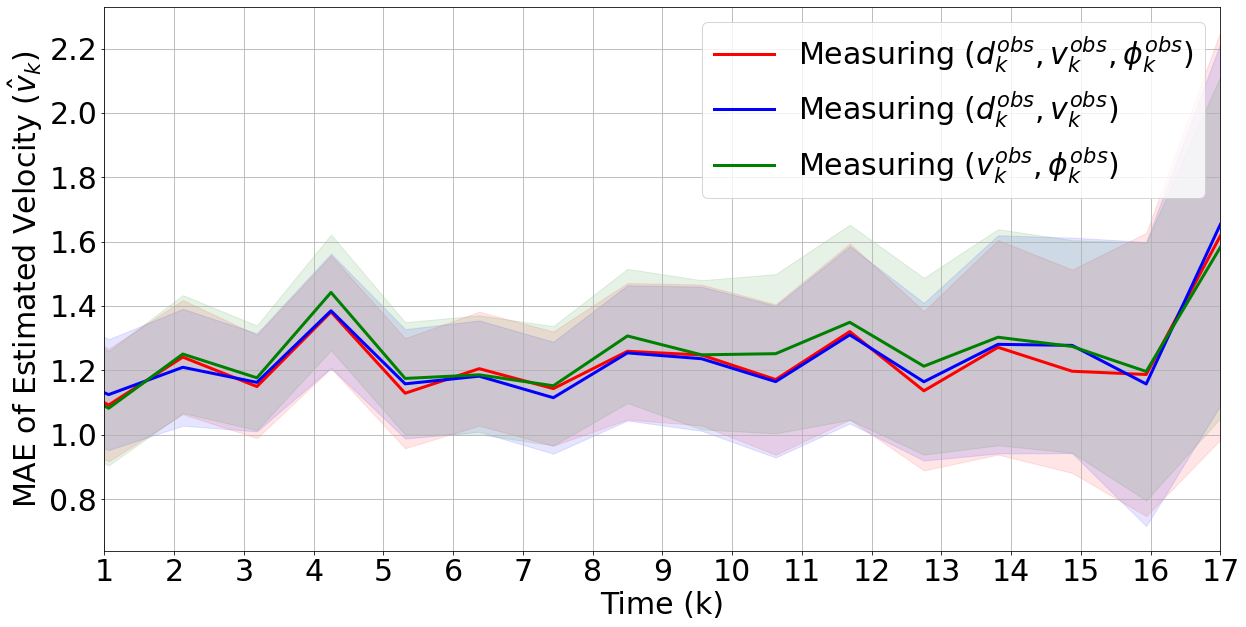

In [174]:
# plot MAE of Estimated Velocity for different sets of measurements

steps = min(len(v_MAE_list_obs_1), len(v_MAE_list_obs_2), len(v_MAE_list_obs_3))
t = np.linspace(0, steps, steps)

v_lower_ci_obs_1 = [v_MAE_list_obs_1[i]-v_ci_obs_1[i] for i in range(steps)]
v_upper_ci_obs_1 = [v_MAE_list_obs_1[i]+v_ci_obs_1[i] for i in range(steps)]

v_lower_ci_obs_2 = [v_MAE_list_obs_2[i]-v_ci_obs_2[i] for i in range(steps)]
v_upper_ci_obs_2 = [v_MAE_list_obs_2[i]+v_ci_obs_2[i] for i in range(steps)]

v_lower_ci_obs_3 = [v_MAE_list_obs_3[i]-v_ci_obs_3[i] for i in range(steps)]
v_upper_ci_obs_3 = [v_MAE_list_obs_3[i]+v_ci_obs_3[i] for i in range(steps)]

plt.figure(figsize=(20,10))

plt.plot(t,v_MAE_list_obs_1[:steps], color='r', label=r'Measuring ($d^{obs}_k ,v^{obs}_k, \phi^{obs}_k$)', linewidth=3)
plt.fill_between(t, v_lower_ci_obs_1, v_upper_ci_obs_1, color='r', alpha=.1)


plt.plot(t,v_MAE_list_obs_2[:steps], color='b', label=r'Measuring ($d^{obs}_k ,v^{obs}_k$)' , linewidth=3)
plt.fill_between(t, v_lower_ci_obs_2, v_upper_ci_obs_2, color='b', alpha=.1)

plt.plot(t,v_MAE_list_obs_3[:steps], color='g', label=r'Measuring ($v^{obs}_k, \phi^{obs}_k$)', linewidth=3)
plt.fill_between(t, v_lower_ci_obs_3, v_upper_ci_obs_3, color='g', alpha=.1)

# plt.title('MAE for Estimation of Velocity, with Confidence Interval of 90%')
plt.xlabel('Time (k)')
plt.xticks(np.arange(steps+1), np.arange(0, steps+1))
plt.xlim((1,steps))
plt.ylabel(r'MAE of Estimated Velocity ($\hat v_k$)')
plt.legend(loc='upper right')
plt.grid()
plt.savefig('v_MAE_differentObservation.png',bbox_inches='tight')
plt.show()


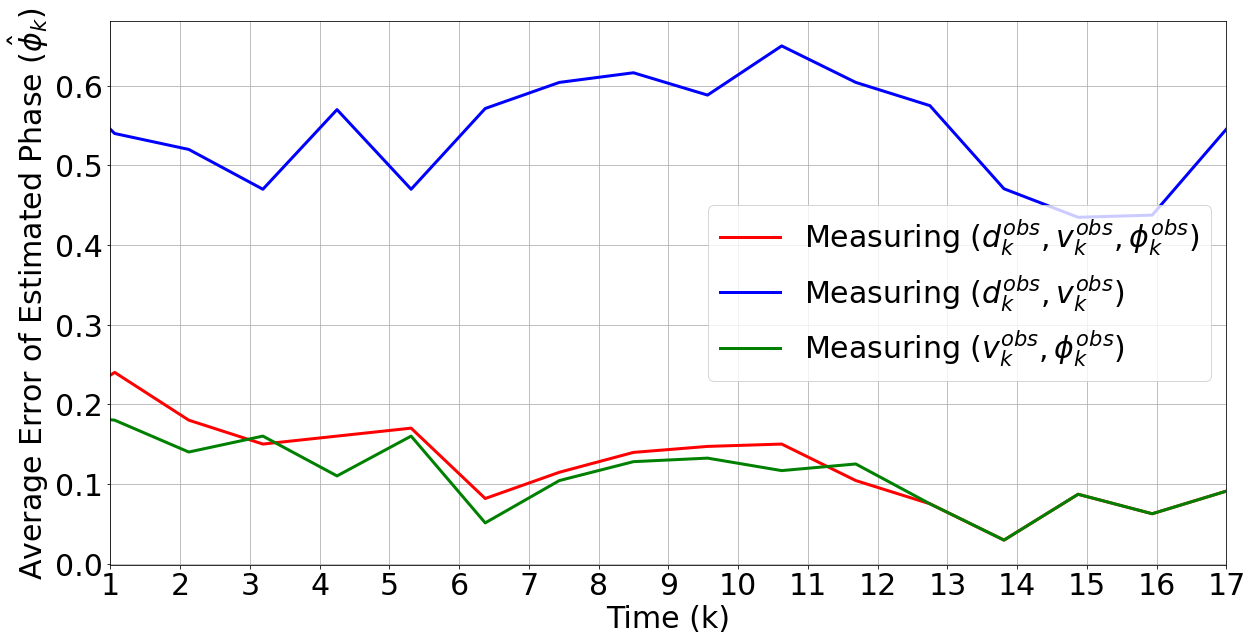

In [175]:
# plot Average Error of Estimated Phase for different sets of measurements

steps = min(len(incorrect_phi_list_obs_1), len(incorrect_phi_list_obs_2), len(incorrect_phi_list_obs_3))
t = np.linspace(0, steps, steps)

plt.figure(figsize=(20,10))
plt.plot(t,incorrect_phi_list_obs_1[:steps], color='r', label=r'Measuring ($d^{obs}_k ,v^{obs}_k, \phi^{obs}_k$)', linewidth=3)

plt.plot(t,incorrect_phi_list_obs_2[:steps], color='b', label=r'Measuring ($d^{obs}_k ,v^{obs}_k$)', linewidth=3)

plt.plot(t,incorrect_phi_list_obs_3[:steps], color='g', label=r'Measuring ($v^{obs}_k, \phi^{obs}_k$)', linewidth=3)

# plt.title('Error of Phase Estimation')
plt.xlabel('Time (k)')
plt.xticks(np.arange(steps+1), np.arange(0, steps+1))
plt.xlim((1,steps))
plt.ylabel(r'Average Error of Estimated Phase ($\hat \phi_k$)')
plt.legend(loc='center right')
plt.grid()
plt.savefig('PhaseError_differentObservation.png',bbox_inches='tight')
plt.show()

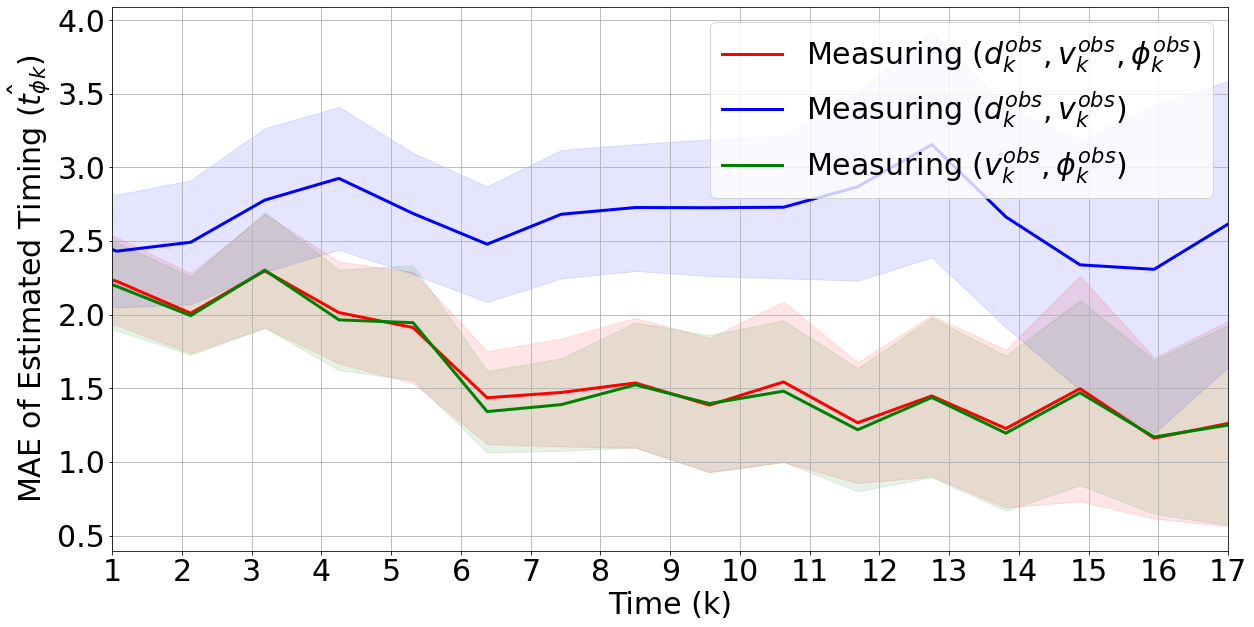

In [176]:
# plot MAE of Estimated Timing for different sets of measurements


steps = min(len(t_MAE_list_obs_1), len(t_MAE_list_obs_2), len(t_MAE_list_obs_3))
t = np.linspace(0, steps, steps)

t_lower_ci_obs_1 = [t_MAE_list_obs_1[i]-t_ci_obs_1[i] for i in range(steps)]
t_upper_ci_obs_1 = [t_MAE_list_obs_1[i]+t_ci_obs_1[i] for i in range(steps)]

t_lower_ci_obs_2 = [t_MAE_list_obs_2[i]-t_ci_obs_2[i] for i in range(steps)]
t_upper_ci_obs_2 = [t_MAE_list_obs_2[i]+t_ci_obs_2[i] for i in range(steps)]

t_lower_ci_obs_3 = [t_MAE_list_obs_3[i]-t_ci_obs_3[i] for i in range(steps)]
t_upper_ci_obs_3 = [t_MAE_list_obs_3[i]+t_ci_obs_3[i] for i in range(steps)]

plt.figure(figsize=(20,10))

plt.plot(t,t_MAE_list_obs_1[:steps], color='r', label=r'Measuring ($d^{obs}_k ,v^{obs}_k, \phi^{obs}_k$)', linewidth=3)
plt.fill_between(t, t_lower_ci_obs_1, t_upper_ci_obs_1, color='r', alpha=.1)


plt.plot(t,t_MAE_list_obs_2[:steps], color='b', label=r'Measuring ($d^{obs}_k ,v^{obs}_k$)' , linewidth=3)
plt.fill_between(t, t_lower_ci_obs_2, t_upper_ci_obs_2, color='b', alpha=.1)

plt.plot(t,t_MAE_list_obs_3[:steps], color='g', label=r'Measuring ($v^{obs}_k, \phi^{obs}_k$)', linewidth=3)
plt.fill_between(t, t_lower_ci_obs_3, t_upper_ci_obs_3, color='g', alpha=.1)

# plt.title('MAE for Estimation of Time of Phase, with Confidence Interval of 90%')
plt.xlabel('Time (k)')
plt.xticks(np.arange(steps+1), np.arange(0, steps+1))
plt.xlim((1,steps))
plt.ylabel(r'MAE of Estimated Timing ($\hat {t_\phi}_k$)')
plt.legend(loc='upper right')
plt.grid()
plt.savefig('t_MAE_differentObservation.png',bbox_inches='tight')
plt.show()


In [177]:
#returns the average error of state estimation with particle filtering for the case that a constant value is considered for the probability of correct phase recognition
d_MAE_list_prob_constant, d_ci_prob_1, v_MAE_list_prob_constant, v_ci_prob_1, incorrect_phi_prob_constant, t_MAE_list_prob_constant, t_ci_prob_1 = particle_filtering_phi_prob('c', all_trajectories, all_accelerations, obs_all_trajectories, N, max_steps, phi_list, T_Y, T_R, T_G, phi_T_dict, phi_next_phi_dict, d_lower, d_upper, v_lower, v_upper, discrete_d, discrete_v, discrete_phi_t, std_d, std_v, std_d_m, std_v_m, phi_obs_prob)


In [178]:
#generates the trajectories, taken actions, and the observations considering a linear function for the probability of correct phase recognition
all_trajectories_prob, all_accelerations_prob, obs_all_trajectories_prob = create_trajectories(d_lower, d_upper, v_lower, v_upper, discrete_d, discrete_v, discrete_phi_t, T_Y, T_G, T_R, phi_next_phi_dict, std_d, std_v, std_t_phi, std_d_m, std_v_m, 'v',0.7)

#returns the average error of state estimation with particle filtering for the case that a linear function is considered for the probability of correct phase recognition. 
d_MAE_list_prob_linear, d_ci_prob_2, v_MAE_list_prob_linear, v_ci_prob_2, incorrect_phi_prob_linear, t_MAE_list_prob_linear, t_ci_prob_2 = particle_filtering_phi_prob('v', all_trajectories_prob, all_accelerations_prob, obs_all_trajectories_prob, N, max_steps, phi_list, T_Y, T_R, T_G, phi_T_dict, phi_next_phi_dict, d_lower, d_upper, v_lower, v_upper, discrete_d, discrete_v, discrete_phi_t, std_d, std_v, std_d_m, std_v_m, 0.7)


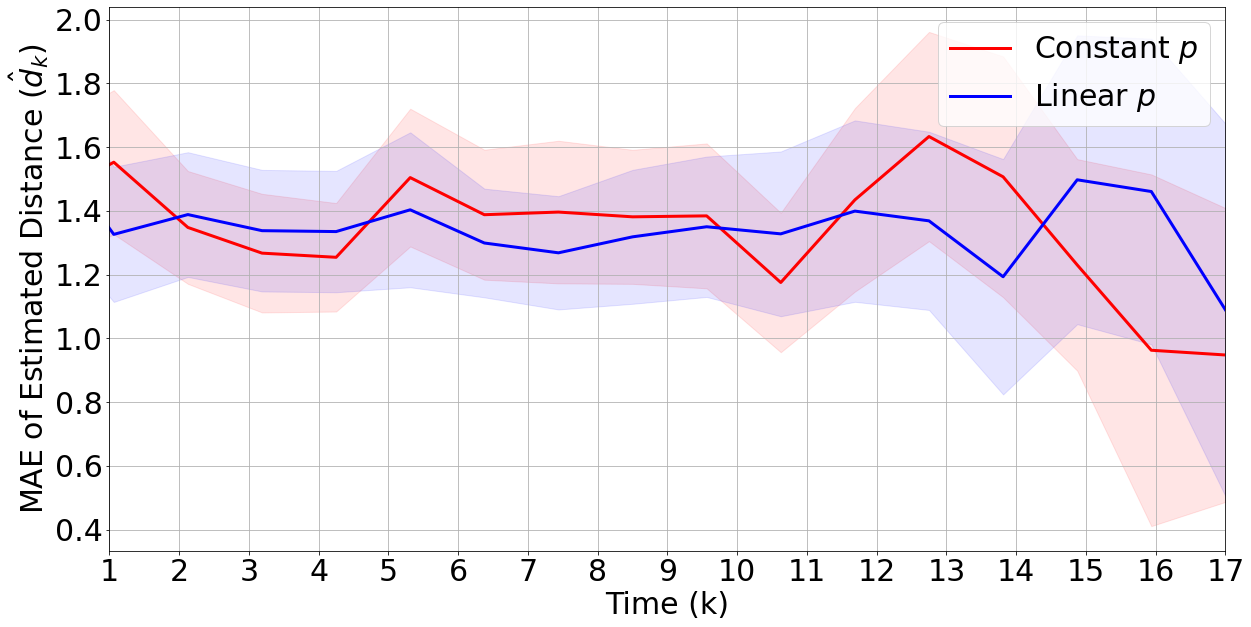

In [179]:
#plot MAE of estimated distance for two cases of constant and variable probability of correct phase recognition

steps = min(len(d_MAE_list_prob_constant), len(d_MAE_list_prob_linear))
t = np.linspace(0, steps, steps)

d_lower_ci_prob_1 = [d_MAE_list_prob_constant[i]-d_ci_prob_1[i] for i in range(steps)]
d_upper_ci_prob_1 = [d_MAE_list_prob_constant[i]+d_ci_prob_1[i] for i in range(steps)]

d_lower_ci_prob_2 = [d_MAE_list_prob_linear[i]-d_ci_prob_2[i] for i in range(steps)]
d_upper_ci_prob_2 = [d_MAE_list_prob_linear[i]+d_ci_prob_2[i] for i in range(steps)]

# d_lower_ci_3 = [d_MAE_list_scenario_3[i]-d_ci_3[i] for i in range(steps)]
# d_upper_ci_3 = [d_MAE_list_scenario_3[i]+d_ci_3[i] for i in range(steps)]

plt.figure(figsize=(20,10))

plt.plot(t,d_MAE_list_prob_constant[:steps], color='r', label=r'Constant $p$', linewidth=3)
# Measuring (d^{obs}_k \, , \, v^{obs}_k  \, , \, \phi^{obs}_k)
plt.fill_between(t, d_lower_ci_prob_1, d_upper_ci_prob_1, color='r', alpha=.1)


plt.plot(t,d_MAE_list_prob_linear[:steps], color='b', label=r'Linear $p$' , linewidth=3)
plt.fill_between(t, d_lower_ci_prob_2, d_upper_ci_prob_2, color='b', alpha=.1)

# plt.plot(t,d_MAE_list_scenario_3[:steps], color='g', label=r'Measuring ($v^{obs}_k, \phi^{obs}_k$)', linewidth=3)
# plt.fill_between(t, d_lower_ci_3, d_upper_ci_3, color='g', alpha=.1)

# plt.title('MAE for Estimation of Distance, with Confidence Interval of 90%')
plt.xlabel('Time (k)')
plt.xticks(np.arange(steps+1), np.arange(0, steps+1))
plt.xlim((1,steps))
plt.ylabel(r'MAE of Estimated Distance ($\hat d_k$)')
plt.legend(loc='upper right')
plt.grid()

plt.savefig('d_MAE_phiProb.png',bbox_inches='tight')
plt.show()

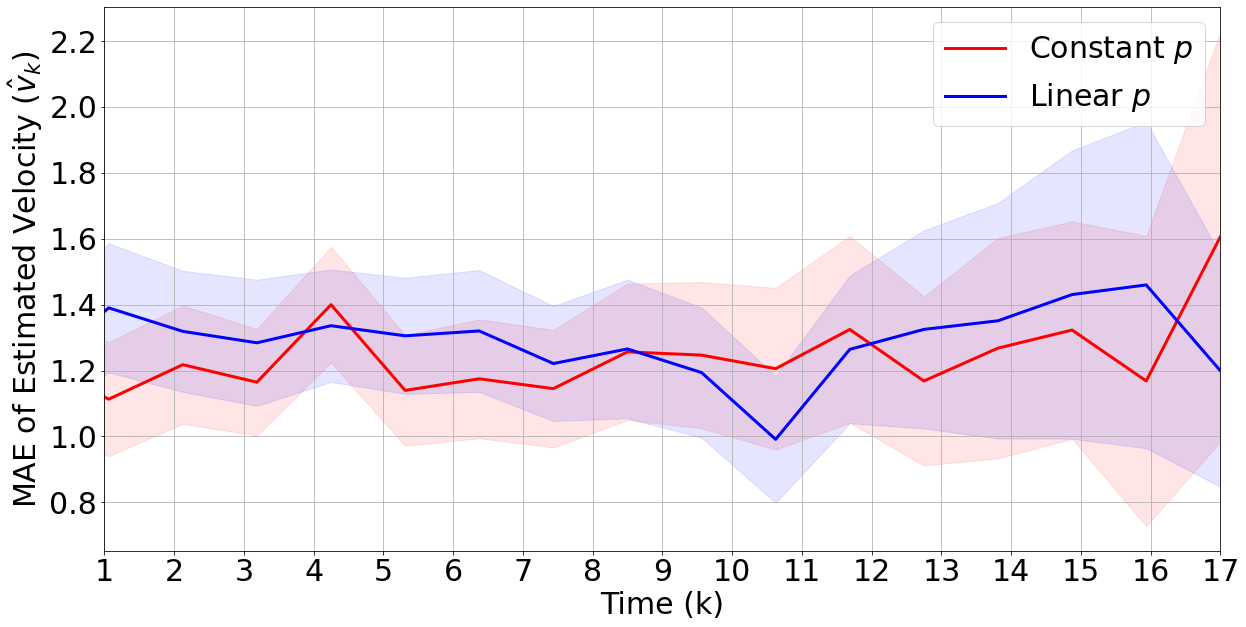

In [180]:
#plot the MAE of estimated velocity for two cases of constant and variable probaility of correct phase recognition

steps = min(len(v_MAE_list_prob_constant), len(v_MAE_list_prob_linear))
t = np.linspace(0, steps, steps)

v_lower_ci_prob_1 = [v_MAE_list_prob_constant[i]-v_ci_prob_1[i] for i in range(steps)]
v_upper_ci_prob_1 = [v_MAE_list_prob_constant[i]+v_ci_prob_1[i] for i in range(steps)]

v_lower_ci_prob_2 = [v_MAE_list_prob_linear[i]-v_ci_prob_2[i] for i in range(steps)]
v_upper_ci_prob_2 = [v_MAE_list_prob_linear[i]+v_ci_prob_2[i] for i in range(steps)]

# d_lower_ci_3 = [d_MAE_list_scenario_3[i]-d_ci_3[i] for i in range(steps)]
# d_upper_ci_3 = [d_MAE_list_scenario_3[i]+d_ci_3[i] for i in range(steps)]

plt.figure(figsize=(20,10))

plt.plot(t,v_MAE_list_prob_constant[:steps], color='r', label=r'Constant $p$', linewidth=3)
# Measuring (d^{obs}_k \, , \, v^{obs}_k  \, , \, \phi^{obs}_k)
plt.fill_between(t, v_lower_ci_prob_1, v_upper_ci_prob_1, color='r', alpha=.1)


plt.plot(t,v_MAE_list_prob_linear[:steps], color='b', label=r'Linear $p$' , linewidth=3)
plt.fill_between(t, v_lower_ci_prob_2, v_upper_ci_prob_2, color='b', alpha=.1)

# plt.plot(t,d_MAE_list_scenario_3[:steps], color='g', label=r'Measuring ($v^{obs}_k, \phi^{obs}_k$)', linewidth=3)
# plt.fill_between(t, d_lower_ci_3, d_upper_ci_3, color='g', alpha=.1)

# plt.title('MAE for Estimation of Distance, with Confidence Interval of 90%')
plt.xlabel('Time (k)')
plt.xticks(np.arange(steps+1), np.arange(0, steps+1))
plt.xlim((1,steps))
plt.ylabel(r'MAE of Estimated Velocity ($\hat v_k$)')
plt.legend(loc='upper right')
plt.grid()

plt.savefig('v_MAE_phiProb.png',bbox_inches='tight')
plt.show()

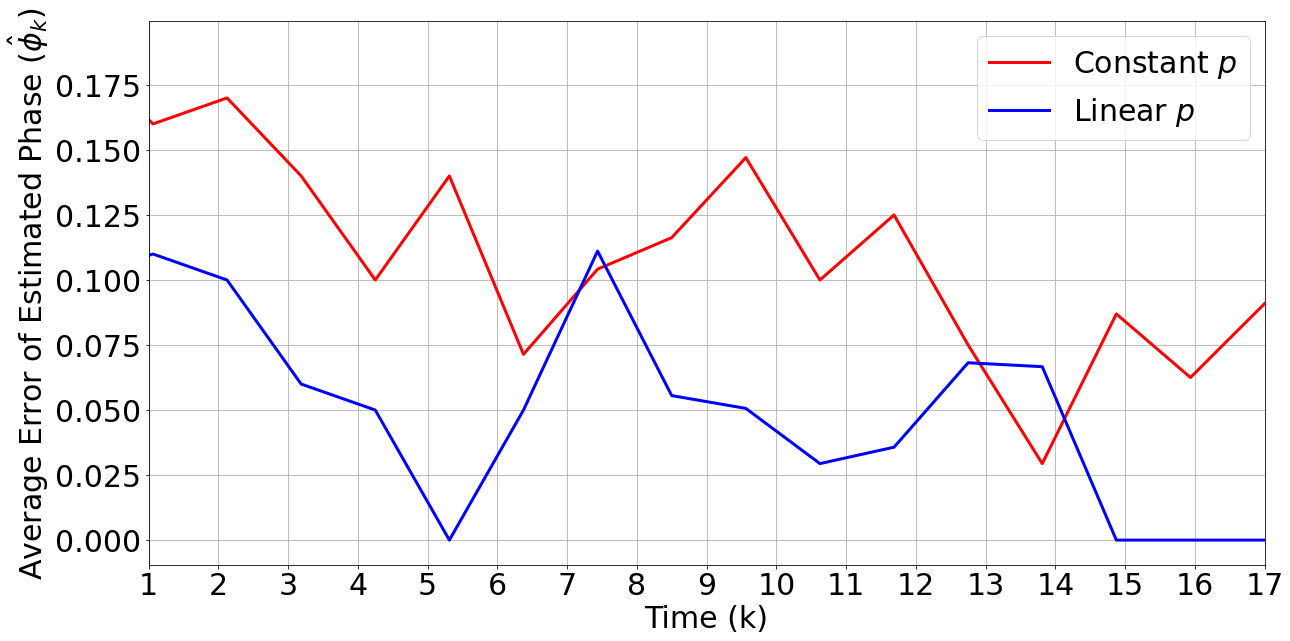

In [181]:
#plot the average error of estimated phase for two cases of constant and variable probability of correct phase recogniton

steps = min(len(incorrect_phi_prob_constant), len(incorrect_phi_prob_linear))
t = np.linspace(0, steps, steps)

plt.figure(figsize=(20,10))
plt.plot(t,incorrect_phi_prob_constant[:steps], color='r', label=r'Constant $p$', linewidth=3)

plt.plot(t,incorrect_phi_prob_linear[:steps], color='b', label=r'Linear $p$', linewidth=3)

# plt.plot(t,incorrect_phi_list_3[:steps], color='g', label=r'Measuring ($v^{obs}_k, \phi^{obs}_k$)', linewidth=3)

# plt.title('Error of Phase Estimation')
plt.xlabel('Time (k)')
plt.xticks(np.arange(steps+1), np.arange(0, steps+1))
plt.xlim((1,steps))
plt.ylabel(r'Average Error of Estimated Phase ($\hat \phi_k$)')
plt.legend(loc='upper right')
plt.grid()
plt.savefig('PhaseError_phiProb.png',bbox_inches='tight')
plt.show()

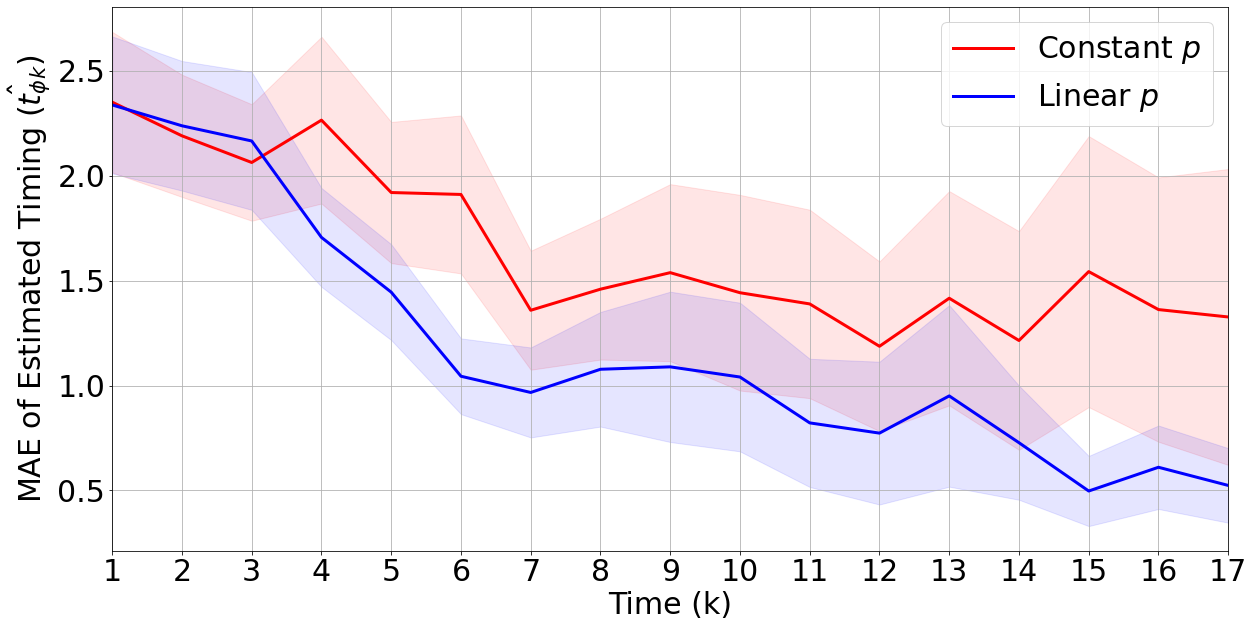

In [182]:
#plot the MAE of estimated timing for two cases of constant and variable probability of correct phase recognition

steps = min(len(t_MAE_list_prob_constant), len(t_MAE_list_prob_linear))
t = np.linspace(1, steps, steps)

t_lower_ci_prob_1 = [t_MAE_list_prob_constant[i]-t_ci_prob_1[i] for i in range(steps)]
t_upper_ci_prob_1 = [t_MAE_list_prob_constant[i]+t_ci_prob_1[i] for i in range(steps)]

t_lower_ci_prob_2 = [t_MAE_list_prob_linear[i]-t_ci_prob_2[i] for i in range(steps)]
t_upper_ci_prob_2 = [t_MAE_list_prob_linear[i]+t_ci_prob_2[i] for i in range(steps)]

# t_lower_ci_3 = [t_MAE_list_scenario_3[i]-t_ci_3[i] for i in range(steps)]
# t_upper_ci_3 = [t_MAE_list_scenario_3[i]+t_ci_3[i] for i in range(steps)]

plt.figure(figsize=(20,10))

plt.plot(t,t_MAE_list_prob_constant[:steps], color='r', label=r'Constant $p$', linewidth=3)
plt.fill_between(t, t_lower_ci_prob_1, t_upper_ci_prob_1, color='r', alpha=.1)


plt.plot(t,t_MAE_list_prob_linear[:steps], color='b', label=r'Linear $p$' , linewidth=3)
plt.fill_between(t, t_lower_ci_prob_2, t_upper_ci_prob_2, color='b', alpha=.1)

# plt.plot(t,t_MAE_list_scenario_3[:steps], color='g', label=r'Measuring ($v^{obs}_k, \phi^{obs}_k$)', linewidth=3)
# plt.fill_between(t, t_lower_ci_3, t_upper_ci_3, color='g', alpha=.1)

# plt.title('MAE for Estimation of Time of Phase, with Confidence Interval of 90%')
plt.xlabel('Time (k)')
plt.xticks(np.arange(steps+1), np.arange(0, steps+1))
plt.xlim((1,steps))
plt.ylabel(r'MAE of Estimated Timing ($\hat {t_\phi}_k$)')
plt.legend(loc='upper right')
plt.grid()
plt.savefig('t_MAE_phiProb.png',bbox_inches='tight')
plt.show()
